## Understanding the problem

Predicting the country of a new user's first booking is beneficial for Airbnb as it enables personalized marketing, improves user experience, and allows for efficient resource allocation. It also helps in host acquisition and retention and provides a competitive advantage. By leveraging these accurate predictions, Airbnb can optimize its business strategies, enhance user satisfaction, and maximize revenue, leading to sustained growth and long-term success.

## 0.0. Imports

In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
import numpy as np
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize 
from category_encoders import CatBoostEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

## 0.1. Read data

In [2]:
data_train = pd.read_csv('train_users.csv')

In [3]:
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

## 1.0 Data description

In [4]:
data_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [241]:
data_train['signup_method'].value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

In [5]:
data_train.shape

(213451, 16)

In [6]:
data_train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

Analyzing the information we soon realized that:
- date_account_created is an object, when it should be datetime type.
- timestamp_first_active is like int64 because it is an integer without divisions (20090319043255). this one should also be a datetime type.
- age should be int64.
We need to create transformers for these columns and also for the other categorical variables.

In [8]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
timestamp_first_active,213451.0,2.013085e+13,9.253717e+09,2.009032e+13,2.012123e+13,2.013091e+13,2.014031e+13,2.014063e+13
age,125461.0,4.966834e+01,1.556666e+02,1.000000e+00,2.800000e+01,3.400000e+01,4.300000e+01,2.014000e+03
signup_flow,213451.0,3.267387e+00,7.637707e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01


## 1.1 Data Exploratory Analysis (Univariate)

In [9]:
df_analysis = data_train.drop('id', axis = 1)

### 1.1.1 Numerical Features

#### Age

In [10]:
df_analysis['age'].value_counts()

30.0      6124
31.0      6016
29.0      5963
28.0      5939
32.0      5855
          ... 
1925.0       1
1935.0       1
1933.0       1
112.0        1
1926.0       1
Name: age, Length: 127, dtype: int64

(0.0, 100.0)

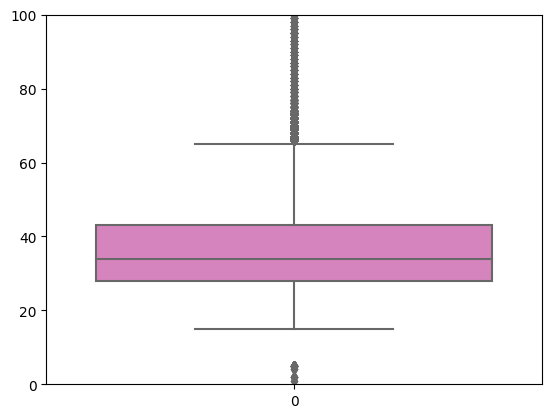

In [11]:
sns.boxplot(data=df_analysis['age'],color=sns.color_palette()[6])
plt.ylim(0,100)

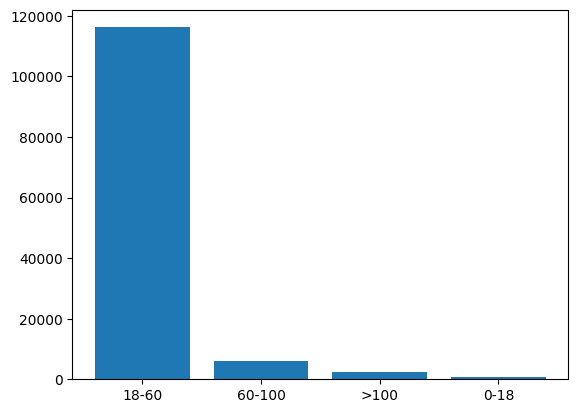

In [12]:
bins = [0, 18, 60,100, float('inf')]
labels = ['0-18','18-60', '60-100','>100']
categories = pd.cut(df_analysis['age'], bins=bins, labels=labels)

value_counts = categories.value_counts()
plt.bar(value_counts.index, value_counts.values)

plt.show()

1- As we can see, there are many outliers in user ages, including ages that are impossible to exist. Most likely this is due to the careless registration of the user.

2- Analyzing the data without considering the outliers, we can see that the average age of users is close to 35 years old.

3- Most users are between 18 and 60 years old.

#### Signup flow

In [13]:
df_analysis['signup_flow'].value_counts()

0     164739
25     14659
12      9329
3       8822
2       6881
24      4328
23      2835
1       1047
6        301
8        240
21       196
5         36
20        14
16        11
15        10
10         2
4          1
Name: signup_flow, dtype: int64

<AxesSubplot: xlabel='signup_flow', ylabel='Count'>

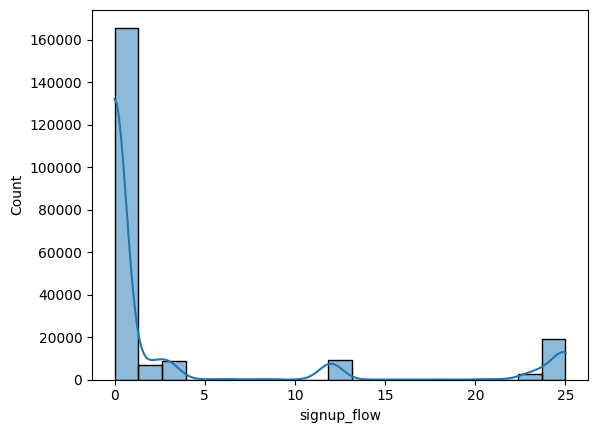

In [14]:
sns.histplot(data=df_analysis['signup_flow'], kde=True)

- Most users have no signup flow

### 1.1.2 Categorical Features

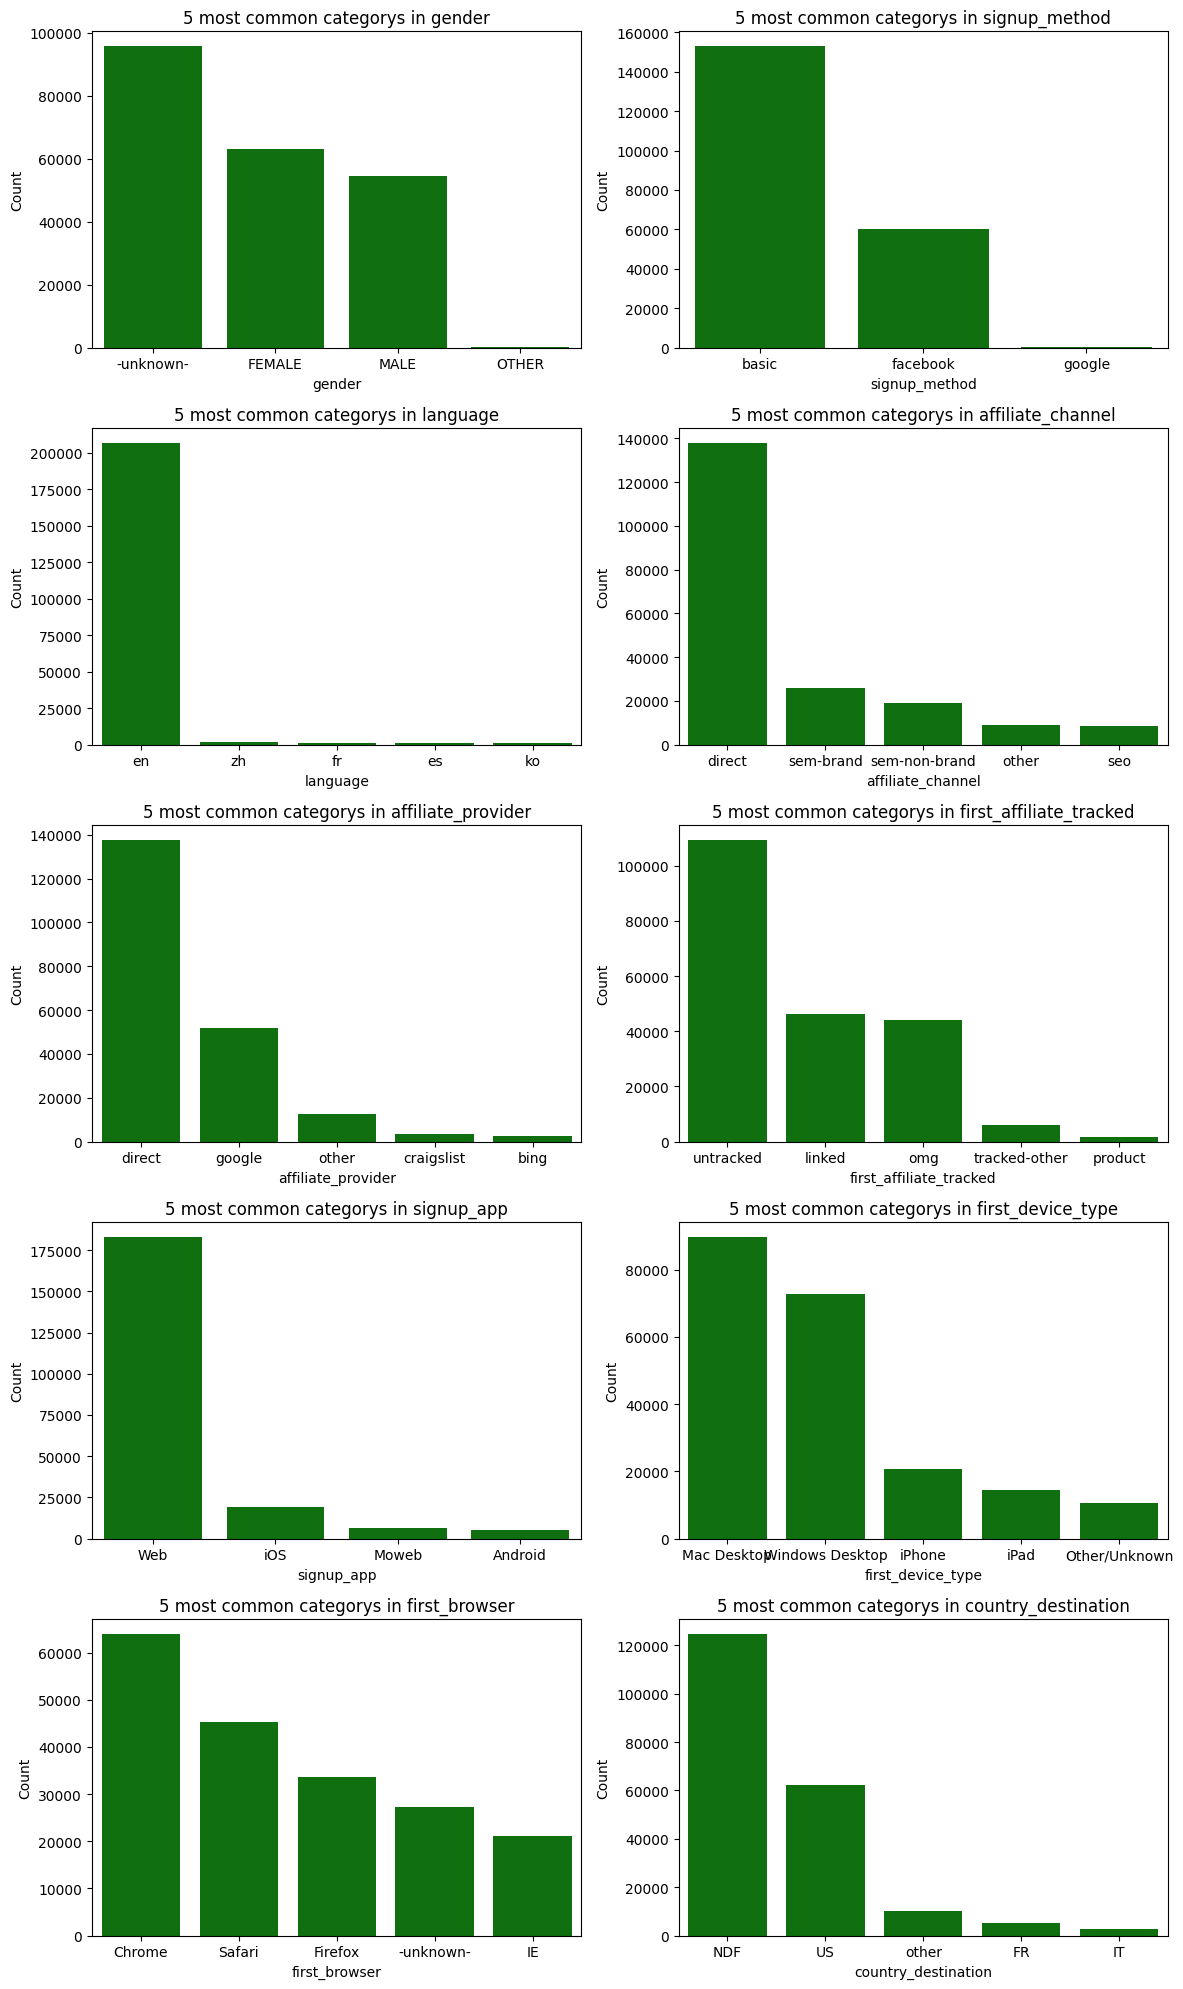

In [15]:
categorical_features = ['gender',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

fig, axs = plt.subplots(5, 2, figsize=(12, 20))
axs = axs.flatten()

for i, coluna in enumerate(categorical_features):
    top_5_categories = df_analysis[coluna].value_counts().head(5)

    sns.countplot(data=df_analysis, x=coluna, order=top_5_categories.index, color='green', ax=axs[i])
    
    axs[i].set_xlabel(coluna)
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'5 most common categorys in {coluna}')

plt.tight_layout()
plt.show()


In [16]:
count = 1
print('From the known data, we have:')
for category in df_analysis['gender'].unique()[1:]:
    print(f'{count}- {category} proportion is:' , (df_analysis['gender'].value_counts()[category] * 100 )/df_analysis['gender'].value_counts()[1:].sum())
    count += 1

From the known data, we have:
1- MALE proportion is: 46.228441870536585
2- FEMALE proportion is: 53.53209412124352
3- OTHER proportion is: 0.2394640082198993


## 1.2 Data Exploratory Analysis (Bivariate)

Text(0.5, 1.0, 'Country-Age Distribution')

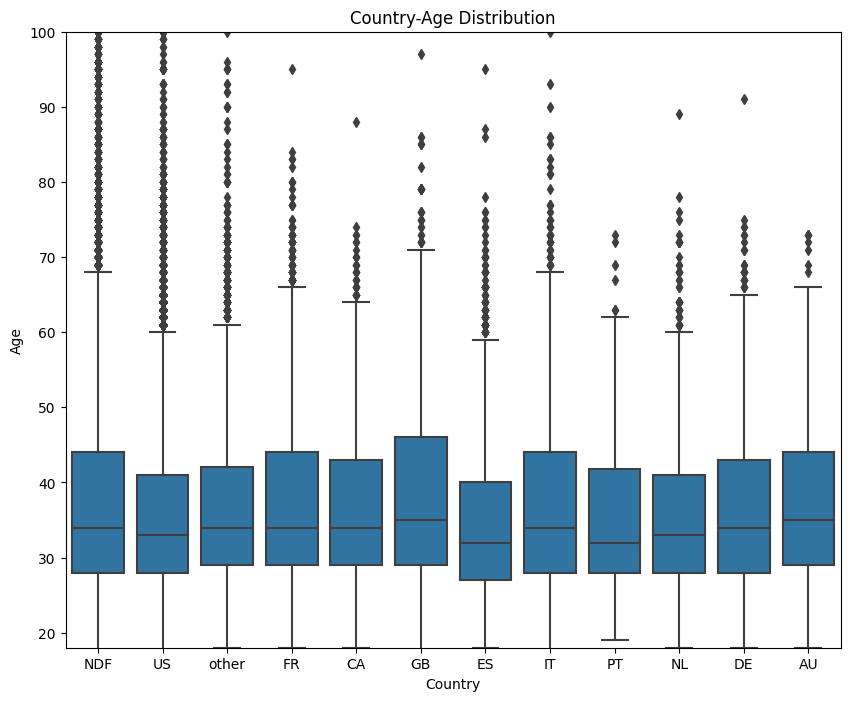

In [17]:
plt.figure(figsize=[10,8])
sns.boxplot(data=df_analysis,y='age',x='country_destination',color=sns.color_palette()[0])
plt.ylim(18,100)
plt.xlabel('Country')
plt.ylabel('Age')
plt.title('Country-Age Distribution')

Text(0.5, 1.0, 'Gender-Age Distribution')

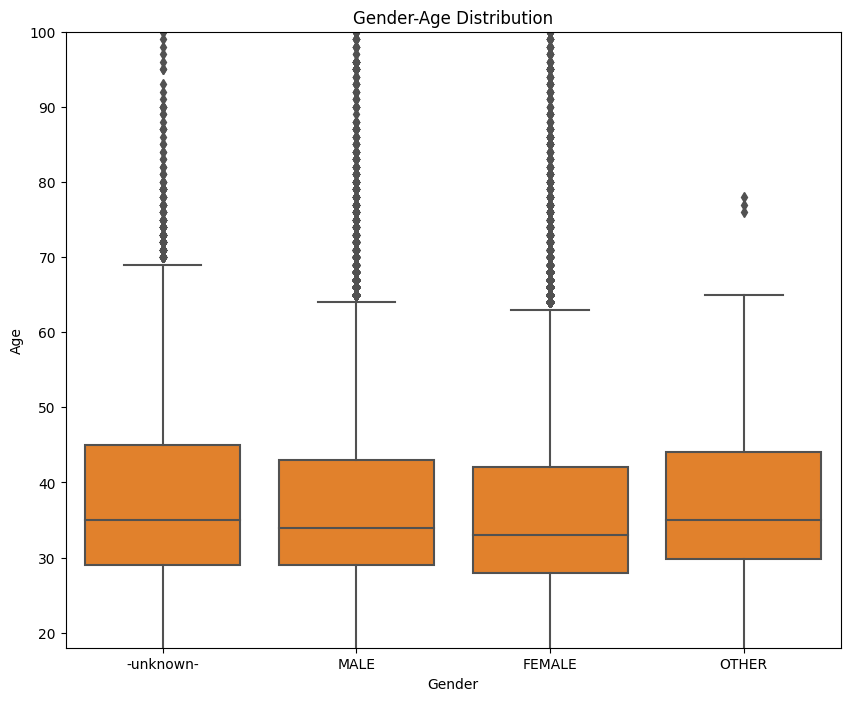

In [18]:
plt.figure(figsize=[10,8])
sns.boxplot(data=df_analysis,y='age',x='gender',color=sns.color_palette()[1])
plt.ylim(18,100)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Gender-Age Distribution')

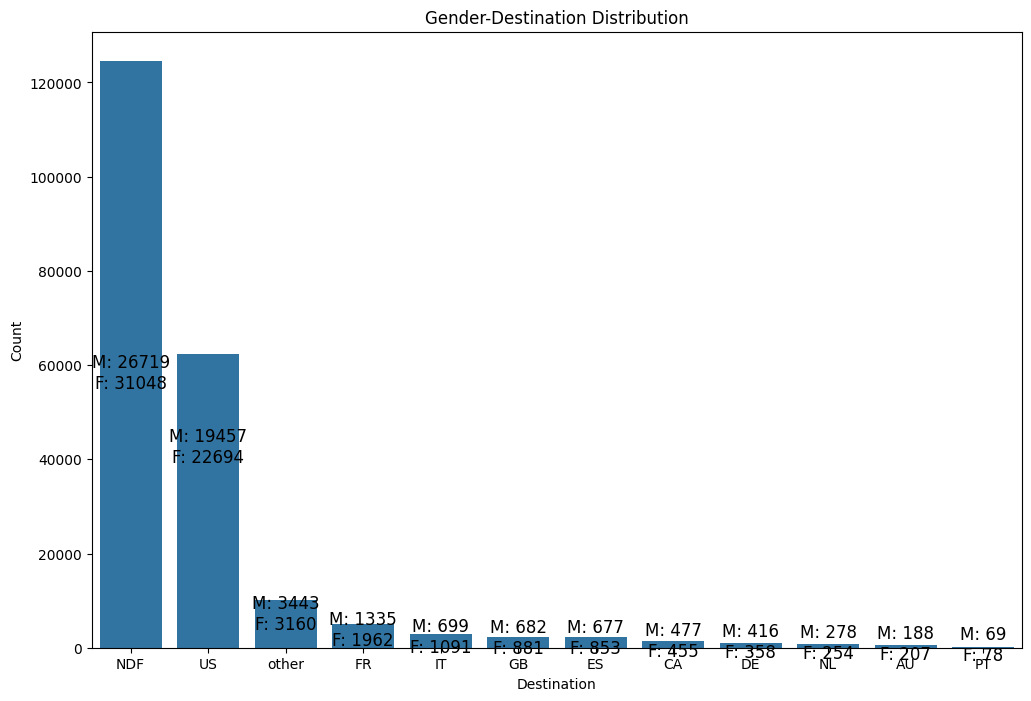

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
order = df_analysis['country_destination'].value_counts().index
sns.countplot(data=df_analysis, x='country_destination', order=order, color=sns.color_palette()[0], ax=ax)
ax.set_xlabel('Destination')
ax.set_ylabel('Count')
ax.set_title('Gender-Destination Distribution')

for i, categoria in enumerate(order):
    count_male = df_analysis[(df_analysis['country_destination'] == categoria) & (df_analysis['gender'] == 'MALE')].shape[0]
    count_female = df_analysis[(df_analysis['country_destination'] == categoria) & (df_analysis['gender'] == 'FEMALE')].shape[0]
    ax.text(i, count_male+count_female+500, f'M: {count_male}\nF: {count_female}', ha='center', va='center', fontsize=12)

plt.show()

## 1.3 Data Exploratory Analysis (Multivariate)

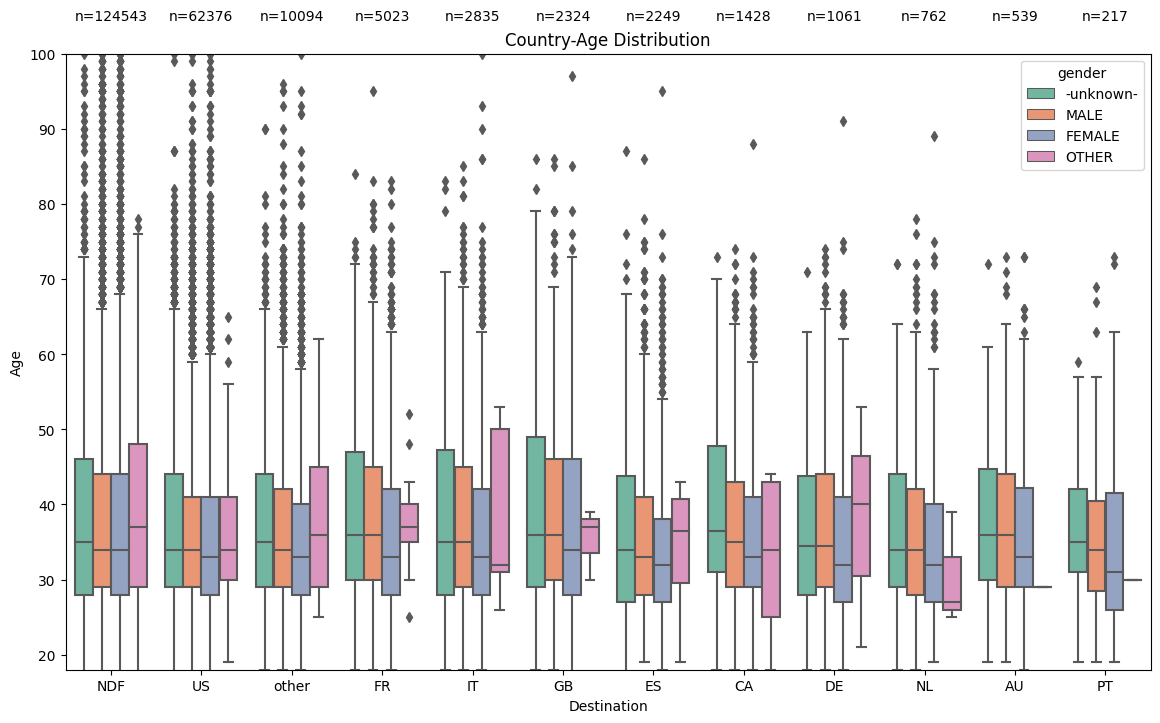

In [20]:
order = df_analysis['country_destination'].value_counts().index

fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=df_analysis, x='country_destination', y='age', hue='gender', order=order, palette='Set2', ax=ax)
plt.ylim(18,100)
ax.set_xlabel('Destination')
ax.set_ylabel('Age')
ax.set_title('Country-Age Distribution')

for i, categoria in enumerate(order):
    count = df_analysis[df_analysis['country_destination'] == categoria].shape[0]
    ax.text(i, ax.get_ylim()[1]*1.05, f'n={count}', ha='center', va='center')

plt.show()

## 1.4 Analysing how browser, app and device are related to user bookings

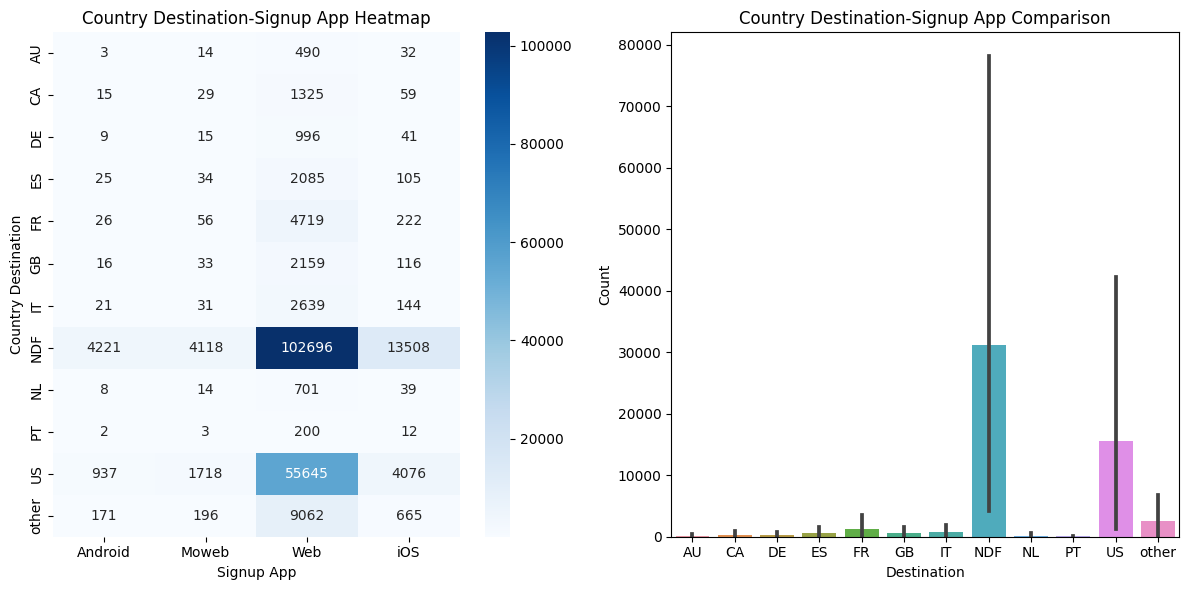

In [21]:
table = pd.crosstab(df_analysis['country_destination'], df_analysis['signup_app'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(table, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Signup App')
axs[0].set_ylabel('Country Destination')
axs[0].set_title('Country Destination-Signup App Heatmap')

stacked = table.stack().reset_index(name='count')

sns.barplot(data=stacked, x='country_destination', y='count', ax=axs[1])
axs[1].set_xlabel('Destination')
axs[1].set_ylabel('Count')
axs[1].set_title('Country Destination-Signup App Comparison')

plt.tight_layout()
plt.show()

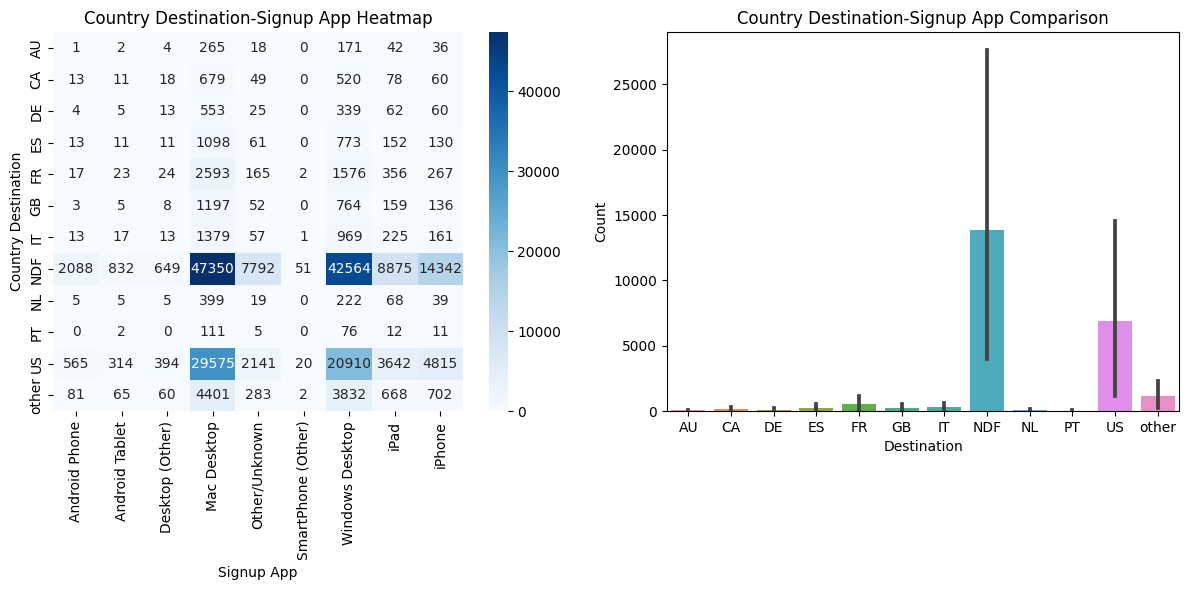

In [22]:
table = pd.crosstab(df_analysis['country_destination'], df_analysis['first_device_type'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(table, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Signup App')
axs[0].set_ylabel('Country Destination')
axs[0].set_title('Country Destination-Signup App Heatmap')

stacked = table.stack().reset_index(name='count')

sns.barplot(data=stacked, x='country_destination', y='count', ax=axs[1])
axs[1].set_xlabel('Destination')
axs[1].set_ylabel('Count')
axs[1].set_title('Country Destination-Signup App Comparison')

plt.tight_layout()
plt.show()

## 1.5 Analysing Time

In [23]:
df_analysis['date_account_created'] = pd.to_datetime(df_analysis['date_account_created'], format='%Y-%m-%d')


In [24]:
df_analysis['timestamp_first_active'] = pd.to_datetime(df_analysis['timestamp_first_active'], format='%Y%m%d%H%M%S')

In [25]:
df_analysis['date_first_booking'] = pd.to_datetime(df_analysis['date_first_booking'], format='%Y-%m-%d')

In [242]:
df_analysis['time_to_create_account'] = (df_analysis['date_account_created'] - df_analysis['timestamp_first_active']).dt.days
df_analysis['time_to_first_booking'] = (df_analysis['date_first_booking'] - df_analysis['timestamp_first_active']).dt.days

In [27]:
df_analysis['time_to_create_account'].value_counts()

-1       213273
 0            7
 6            4
 1            4
 5            4
          ...  
 240          1
 310          1
 327          1
 1017         1
 143          1
Name: time_to_create_account, Length: 143, dtype: int64

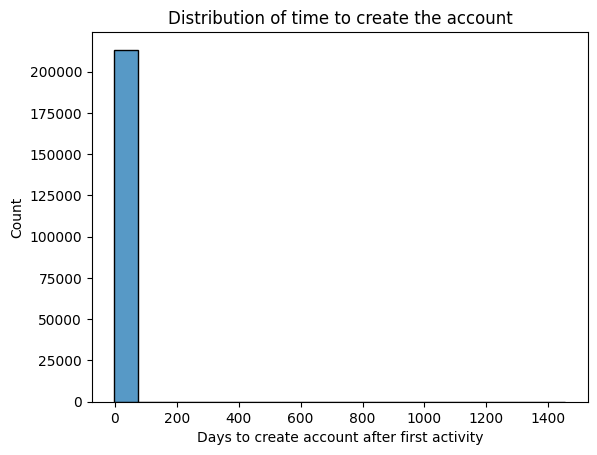

In [28]:
sns.histplot(df_analysis['time_to_create_account'].dropna())
plt.xlabel('Days to create account after first activity')
plt.ylabel('Count')
plt.title('Distribution of time to create the account')
plt.show()

In [29]:
df_analysis['time_to_first_booking'].value_counts()

-1.0      21401
 0.0      14776
 1.0       6522
 2.0       4016
 3.0       2937
          ...  
 531.0        1
 467.0        1
 912.0        1
 554.0        1
 370.0        1
Name: time_to_first_booking, Length: 400, dtype: int64

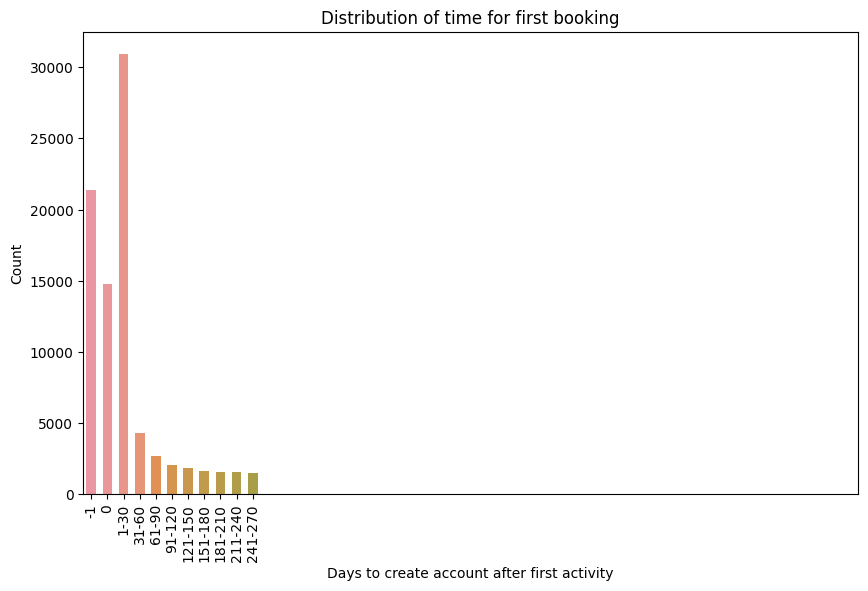

In [30]:
bin_size = 30
bins = [-2, 0] + list(range(1, int(df_analysis['time_to_first_booking'].max()) + bin_size + 1, bin_size))
df_analysis['time_to_first_booking_binned'] = pd.cut(df_analysis['time_to_first_booking'], bins=bins, right=False)
grouped_data = df_analysis['time_to_first_booking_binned'].value_counts().sort_index()

grouped_data = grouped_data.iloc[:11]

plt.figure(figsize=(10, 6))

sns.barplot(x=grouped_data.index, y=grouped_data.values, width=0.6)
plt.xlabel('Days to create account after first activity')
plt.ylabel('Count')
plt.title('Distribution of time for first booking')

labels = ['-1'] + ['0'] + [f'{int(interval.left)}-{int(interval.right)-1}' for interval in grouped_data.index[2:]]
plt.xticks(range(len(labels)), labels, rotation=90)

plt.show()


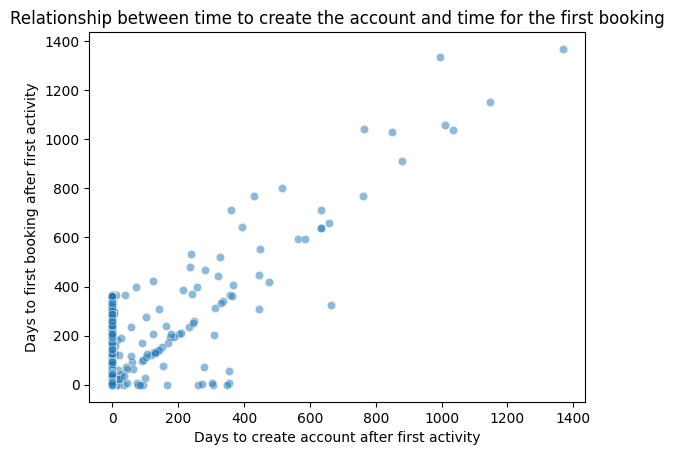

In [31]:
sns.scatterplot(data=df_analysis, x='time_to_create_account', y='time_to_first_booking', alpha=0.5)
plt.xlabel('Days to create account after first activity')
plt.ylabel('Days to first booking after first activity')
plt.title('Relationship between time to create the account and time for the first booking')
plt.show()

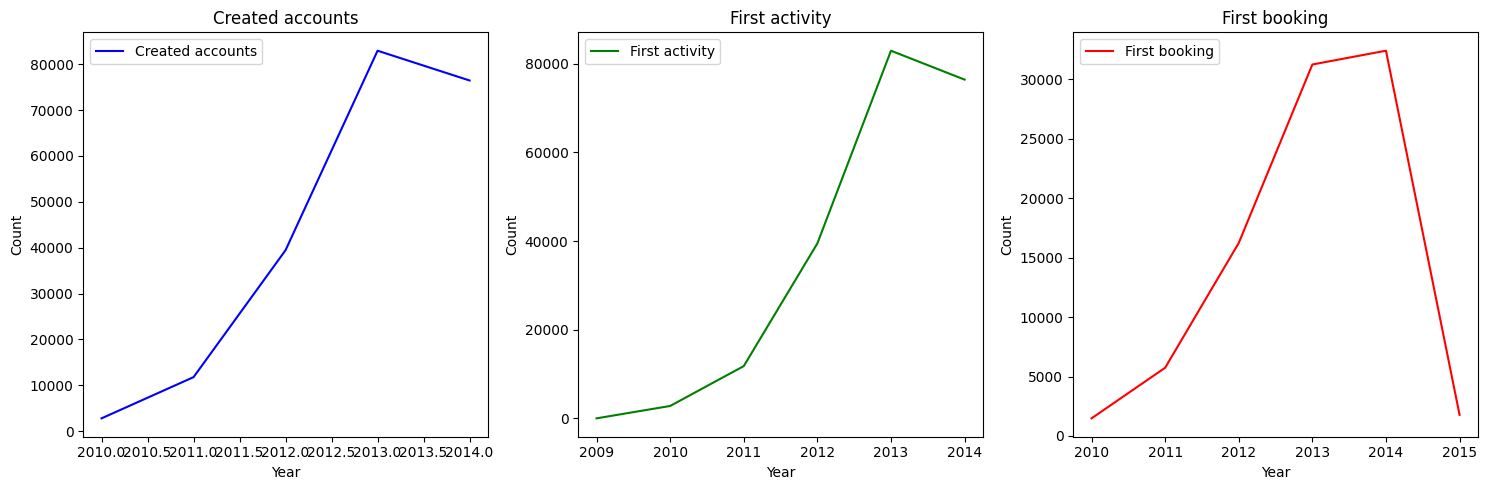

In [32]:
df_analysis['year_account_created'] = df_analysis['date_account_created'].dt.year
df_analysis['year_first_active'] = df_analysis['timestamp_first_active'].dt.year
df_analysis['year_first_booking'] = df_analysis['date_first_booking'].dt.year

grouped_account_created = df_analysis['year_account_created'].value_counts().sort_index()
grouped_first_active = df_analysis['year_first_active'].value_counts().sort_index()
grouped_first_booking = df_analysis['year_first_booking'].value_counts().sort_index()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(grouped_account_created.index, grouped_account_created.values, label='Created accounts', color='blue')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Created accounts')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(grouped_first_active.index, grouped_first_active.values, label='First activity', color='green')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('First activity')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(grouped_first_booking.index, grouped_first_booking.values, label='First booking', color='red')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('First booking')
plt.legend()

plt.tight_layout()

plt.show()


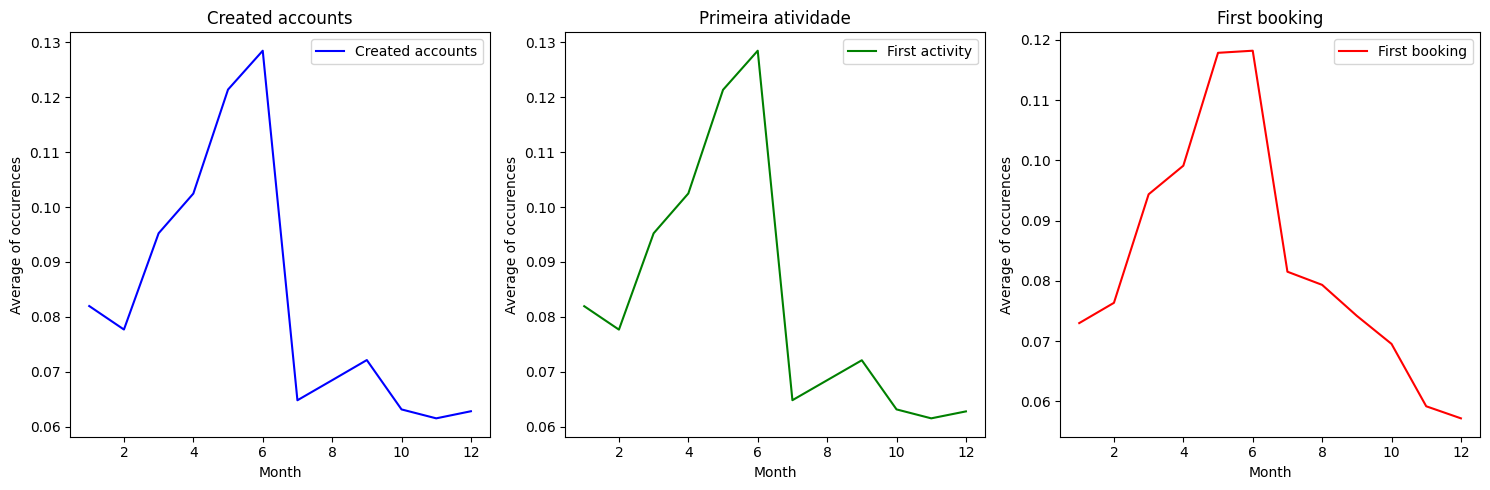

In [33]:
df_analysis['month_account_created'] = df_analysis['date_account_created'].dt.month
df_analysis['month_first_active'] = df_analysis['timestamp_first_active'].dt.month
df_analysis['month_first_booking'] = df_analysis['date_first_booking'].dt.month

grouped_account_created = df_analysis['month_account_created'].value_counts(normalize=True).sort_index()
grouped_first_active = df_analysis['month_first_active'].value_counts(normalize=True).sort_index()
grouped_first_booking = df_analysis['month_first_booking'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(grouped_account_created.index, grouped_account_created.values, label='Created accounts', color='blue')
plt.xlabel('Month')
plt.ylabel('Average of occurences')
plt.title('Created accounts')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(grouped_first_active.index, grouped_first_active.values, label='First activity', color='green')
plt.xlabel('Month')
plt.ylabel('Average of occurences')
plt.title('Primeira atividade')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(grouped_first_booking.index, grouped_first_booking.values, label='First booking', color='red')
plt.xlabel('Month')
plt.ylabel('Average of occurences')
plt.title('First booking')
plt.legend()

# Ajustar o layout
plt.tight_layout()

plt.show()


## 1.6 Inferences and results

- As we can see, most of the gender data is unknown.

- The most common way for a user to sign up is 'basic' followed by 'facebook'.

- There are a lot of users who speak in different languages, but the 3 most common are English, Chinese and French.

- The most common paid marketing approach is direct.

- The most common way to find ads related to Airbnb is direct or through Google.

- Most of the data doesn't tell us much about where the first marketing the user came into contact with before signing up came from.

- Most users access Airbnb through its Web App.

- As seen earlier, most users DO NOT access Airbnb using mobile apps, so most prefer to use desktops and access the web.

- Again, most users prefer to access via browsers used on the Desktop. And the most famous are Google Chrome and Apple's browser, IOS.

- Most users have not yet made their first booking, as the vast majority have 'NDF' status. That is, many register and do not follow the "natural flow" that Airbnb may want.

- Gender data is balanced: 
    - MALE proportion is: 46.228441870536585
    - FEMALE proportion is: 53.53209412124352
    - OTHER proportion is: 0.2394640082198993
    

- Most of the datetime 'time_to_create_account' values ​​resulting from the subtraction are equal to -1, this indicates that most of the accounts were created one day before the first activity registered by the users. This may be due to the first activity including actions taken by users before creating an account, such as browsing the site or searching for information, this may explain why the first activity occurs before account creation.


- A lot of 'time_to_first_booking' values ​​are -1 or 0, this indicates that most users made their first reservation on the same day their account was created (value 0) or that they did not make a reservation (value -1).
    - Value 0 (same day): This suggests that most users were ready to make a reservation right after creating their account. This can be a positive sign for the platform, as it indicates that users are finding what they are looking for quickly and are willing to make a reservation in a short time.

    - Value -1 (no reservation): A value of -1 may indicate that the user has not yet made a reservation. This could be due to several factors, such as a lack of attractive offers, website usability issues or simply because the user is using the platform only for research, with no intention of making a reservation.

    - Value [1-30]: most time_to_first_booking values ​​are between 1 and 30 days, this indicates that most users make their first booking quickly after their first activity on the platform. This could suggest short-term planning, quick decisions, market competition, or general online booking behavior.

- By analyzing the graph and observing the relevant drop in accounts created and in the first activity, while the first booking shows a less pronounced drop, we can infer that this behavior may be due to seasonality. User behavior can be influenced by seasonality, with some months being more likely to create accounts and perform activities than others. The first booking may be less affected by this seasonality, as users may have done research and activities before deciding to book.


## 2.0. Transformers

In [116]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = pd.DataFrame(X.copy())
        for col in self.columns:
            if len(str(X_.loc[X_.index[0], col])) == 14:
                X_[col] = pd.to_datetime(X_[col], format='%Y%m%d%H%M%S')
                X_[f'{col}_year'] = X_[col].dt.year
                X_[f'{col}_month'] = X_[col].dt.month
                X_[f'{col}_day'] = X_[col].dt.day
                X_[f'{col}_hour'] = X_[col].dt.hour
                X_[f'{col}_minute'] = X_[col].dt.minute
                X_[f'{col}_second'] = X_[col].dt.second
            else:
                X_[col] = pd.to_datetime(X_[col])
                X_[f'{col}_year'] = X_[col].dt.year
                X_[f'{col}_month'] = X_[col].dt.month
                X_[f'{col}_day'] = X_[col].dt.day

        return X_.drop(columns=self.columns)
        

## 2.1. Functions

### 2.1.1 Building Pipeline

In [36]:
def train_classifier(X_train, y_train, categorical_features, numeric_features, datetime_features, classifier):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    cat_encoder = CatBoostEncoder()
    X_train_cat_encoded = cat_encoder.fit_transform(X_train[categorical_features], y_train_encoded)
    
    X_train_encoded = X_train.copy()
    X_train_encoded[categorical_features] = X_train_cat_encoded

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    datetime_transformer = Pipeline(steps=[
        ('date_extractor', DateExtractor(columns=datetime_features)),
        ('imputer', SimpleImputer(strategy='mean')),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', 'passthrough', categorical_features),
            ('datetime', datetime_transformer, datetime_features)
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)])
        
    pipeline.fit(X_train_encoded, label_encoder.transform(y_train))
    
    return pipeline, label_encoder, cat_encoder, preprocessor


### 2.1.2 Result Functions

In [37]:
def show_results(y_val_pred, y_val, name):
    cm = confusion_matrix(y_val, y_val_pred)

    plt.figure(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix {name}')

In [38]:
def dcg_score(y_true, y_score, k=5):
    
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score_udf(y_true, y_score, k=5):
    lb = LabelBinarizer()
    lb.fit(np.unique(y_true))
    T = lb.transform(y_true)
    scores = []

    for y_true, y_prob in zip(T, y_score):
        actual = dcg_score(y_true, y_prob, k)
        best = dcg_score(y_true, y_true, k)
        if best == 0:
            score = 0
        else:
            score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

ndcg_scorer = make_scorer(ndcg_score_udf, needs_proba=True, k=5)

In [39]:
def results(df_results, name, y, y_pred_labels, ndcg):
    accuracy = accuracy_score(y, y_pred_labels) * 100
    precision = precision_score(y, y_pred_labels, average='weighted') * 100
    recall = recall_score(y, y_pred_labels, average='weighted') * 100
    f1 = f1_score(y, y_pred_labels, average='weighted') * 100
    kappa = cohen_kappa_score(y, y_pred_labels)
    
    return pd.concat([df_results, pd.DataFrame([[name, accuracy, precision, recall, f1, kappa, ndcg]], columns=df_results.columns)], ignore_index=True)

### 2.1.3 Predict Function

In [40]:
def predict(pipeline, cat_encoder, label_encoder, X, y=None):
    X_cat_encoded = cat_encoder.transform(X[categorical_features])
    X_encoded = X.copy()
    X_encoded[categorical_features] = X_cat_encoded

    predicted_classes = pipeline.predict(X_encoded)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    if y is not None:
        y_true_encoded = label_encoder.transform(y)
        y_pred_proba = pipeline.predict_proba(X_encoded)
        ndcg = ndcg_score_udf(y, y_pred_proba, k=3)
        return predicted_labels, ndcg
    else:
        return predicted_labels

### 2.1.4 Get top probabilities

In [140]:
def get_top_n(prob_array, member_ids, label_encoder, n):
    ids = []
    preds = []
    for i, member_id in enumerate(member_ids):
        ids.extend([member_id]*n)
        top_n_indices = np.argsort(prob_array[i, :])[-n:][::-1]
        for j in range(n):
            preds.append(label_encoder.classes_[top_n_indices[j]])
    return pd.DataFrame({'id': ids, 'country': preds})


## 2.2. Data Split

In [75]:
X = data_train.drop('country_destination', axis=1)
y = data_train['country_destination']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {len(X_train)} | Test: {len(X_test)} | Validation: {len(X_val)}")

Training: 149415 | Test: 32018 | Validation: 32018


In [97]:
categorical_features = [
    'gender',
    'signup_method',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
]

datetime_features = [
        'date_account_created',
        'timestamp_first_active',
        'date_first_booking',
]

numeric_features = [
    'age',
    'signup_flow'
]

## 2.3. Testing Classifiers

In [44]:
df_results = pd.DataFrame(columns=['name', 'accuracy', 'precision', 'recall','f1', 'kappa', 'ndcg'])

In [45]:
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000)),
    
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    
    ('Random Forest', RandomForestClassifier(random_state=42, )),
    
    ('Decision Tree',DecisionTreeClassifier(random_state=42)),

    ('XGB',XGBClassifier(random_state=42)),

    ('LGBM', LGBMClassifier(random_state=42)),

]

In [46]:
for name, classifier in classifiers:
    pipeline, label_encoder, cat_encoder, preprocessor = train_classifier(X_train, y_train, categorical_features, numeric_features, datetime_features, classifier)
    y_pred_labels, ndcg = predict(pipeline, cat_encoder, label_encoder, X_val, y_val)
    df_results = results(df_results, name, y_val, y_pred_labels, ndcg)

In [47]:
df_results.sort_values(by=['ndcg', 'kappa', 'f1'], ascending=[False, False, False], inplace=True)

In [48]:
df_results

,name,accuracy,precision,recall,f1,kappa,ndcg
2,Random Forest,87.372728,78.538610,87.372728,82.174984,0.766332,0.913108
4,XGB,87.353988,79.873221,87.353988,82.191617,0.766056,0.912823
5,LGBM,85.717409,79.234301,85.717409,81.511075,0.738180,0.905260
1,K-Nearest Neighbors,80.595290,72.763220,80.595290,76.094894,0.629495,0.873148
3,Decision Tree,78.615154,79.503147,78.615154,79.043996,0.629911,0.866353
0,Logistic Regression,57.861203,34.413956,57.861203,42.497146,-0.001708,0.789092


The results from XGB and Random Forest are promising, particularly due to the high NDCG and Kappa Scores. The NDCG Score of 0.91 signifies that the model effectively ranks relevant items against less relevant ones, with a score close to 1 considered excellent. The Kappa Score of 0.76 demonstrates good model performance, as a score of 1 indicates perfect agreement between predictions and true values, while a score of 0 implies agreement no better than chance. A score of 0.76 indicates substantial agreement. Furthermore, the XGB and Random Forest models presents good precision, recall, and F1-score, highlighting its solid performance.

## 2.4. Hyper Parameters

In [49]:
classifier = XGBClassifier(random_state=42)

In [50]:
pipeline, label_encoder, cat_encoder, preprocessor = train_classifier(X_train, y_train, categorical_features, numeric_features, datetime_features, classifier)

In [51]:
y_train_encoded = label_encoder.fit_transform(y_train)
X_train_cat_encoded = cat_encoder.fit_transform(X_train[categorical_features], y_train_encoded)

X_train_encoded = X_train.copy()
X_train_encoded[categorical_features] = X_train_cat_encoded

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.5, 0.8, 1],
    'classifier__colsample_bytree': [0.5, 0.8, 1],
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, n_jobs=-1)
random_search.fit(X_train_encoded, label_encoder.transform(y_train))

best_params = random_search.best_params_
best_classifier = XGBClassifier(random_state=42,
                                n_estimators=best_params['classifier__n_estimators'],
                                learning_rate=best_params['classifier__learning_rate'],
                                max_depth=best_params['classifier__max_depth'],
                                subsample=best_params['classifier__subsample'],
                                colsample_bytree=best_params['classifier__colsample_bytree'])


## 2.5. Testing model with new parameters

In [53]:
best_params = random_search.best_params_
best_classifier = XGBClassifier(random_state=42,
                                n_estimators=best_params['classifier__n_estimators'],
                                learning_rate=best_params['classifier__learning_rate'],
                                max_depth=best_params['classifier__max_depth'],
                                subsample=best_params['classifier__subsample'],
                                colsample_bytree=best_params['classifier__colsample_bytree'])

In [158]:
pipeline, label_encoder, cat_encoder, preprocessor = train_classifier(X_train, y_train, categorical_features, numeric_features, datetime_features, best_classifier)
y_pred_labels, ndcg = predict(pipeline, cat_encoder, label_encoder, X_val, y_val)

## 2.6. Using new classifier to predict new data

In [159]:
def test_classifier(df_test, categorical_features, cat_encoder, preprocessor, best_classifier, n):
    df_test_cat_encoded = cat_encoder.transform(df_test[categorical_features])
    df_test_encoded = df_test.copy()
    df_test_encoded[categorical_features] = df_test_cat_encoded
    df_test_preprocessed = preprocessor.transform(df_test_encoded)
    y_pred_proba = best_classifier.predict_proba(df_test_preprocessed)

    member_ids = df_test['id'].values
    df = get_top_n(y_pred_proba, member_ids, label_encoder, n = n)
    return df.set_index('id')

In [160]:
df_test = pd.read_csv('test_users.csv')

In [161]:
dataframe_predctions = test_classifier(df_test, categorical_features, cat_encoder, preprocessor, best_classifier, 1)

In [162]:
dataframe_predctions

,country
id,
5uwns89zht,NDF
jtl0dijy2j,NDF
xx0ulgorjt,NDF
6c6puo6ix0,NDF
czqhjk3yfe,NDF
...,...
cv0na2lf5a,NDF
zp8xfonng8,NDF
fa6260ziny,NDF


In [163]:
dataframe_predctions.to_csv('submission.csv')

## 2.7. Business analysis

By predicting the probabilities of where a user will make their first booking, we can use this information to optimize marketing strategies and increase Airbnb's profit. Let's explore some ways to apply this prediction to the profit formula we discussed earlier:

- Optimizing Customer Acquisition Cost (CAC):
Using predictions to target marketing campaigns and promotions in locations where users are most likely to make their first booking can help reduce the CAC. This is because you will be directing your marketing efforts to areas with the highest likelihood of conversion.

- Increase Total Bookings:
Personalizing offers and accommodation recommendations for users based on predictions of where they will make their first booking, you can increase the likelihood that they will actually make a reservation. This, in turn, increases the total number of bookings, boosting revenue generated from service fees.

- Increase Host and Guest Retention:
Predicting where users will make their first booking, you can also identify areas with high demand and work to attract more hosts to offer accommodations in these locations. This can help increase the supply to meet demand and, consequently, increase retention for both hosts and guests.

To apply these strategies to the profit formula, the main goal is to increase revenue (through service fees and bookings) and reduce costs (primarily CAC and other operational costs). Thus, with the successful implementation of these strategies, we can expect an increase in Airbnb's profit.

The precision and recall of our model help gauge its effectiveness in making correct predictions. We can use these metrics to estimate their impact on optimizing business strategies like marketing campaigns and attracting and retaining hosts and guests. For example, higher precision might be related to a 10% reduction in CAC, while increased recall might result in a 10% increase in both guest and host bookings.

Estimating the impact of your model's precision and recall metrics on business strategies, we can indirectly incorporate them into profit calculations. However, these relationships are assumptions and may not reflect reality. It's crucial to test and validate these assumptions in real-world scenarios and adjust calculations accordingly.

Let's use some hypothetical numbers to illustrate how these strategies can affect Airbnb's profit. Assume that, initially, the following values are true:

- Host_Fee = 4%
- Guest_Fee = 12%
- Total_Host_Bookings = 10,000
- Total_Guest_Bookings = 10,000
- CAC = $40 per customer
- Operational_Costs = $100,000

In [229]:
def calculate_profit(host_fee, guest_fee, total_host_bookings, total_guest_bookings, operational_costs, average_booking_value, CAC):
    revenue = (host_fee * total_host_bookings * average_booking_value) + (guest_fee * total_guest_bookings * average_booking_value)
    total_cost = CAC * total_guest_bookings + operational_costs
    profit = revenue - total_cost
    return profit

In [235]:
host_fee = 0.15
guest_fee = 0.12
total_host_bookings = 100000
total_guest_bookings = 100000 
CAC = 20
operational_costs = 10000
average_booking_value = 100

profite_before_strategies = calculate_profit(host_fee, guest_fee, total_host_bookings, total_guest_bookings, operational_costs, average_booking_value, CAC)

In [236]:
host_fee = 0.15
guest_fee = 0.12
total_host_bookings = 110000
total_guest_bookings = 110000
CAC = 18
operational_costs = 10000
average_booking_value = 100

profit_after_strategies = calculate_profit(host_fee, guest_fee, total_host_bookings, total_guest_bookings, operational_costs, average_booking_value, CAC)

In [240]:
print(f'There was a {((profit_after_strategies/profite_before_strategies) * 100):.2f}% increase in profit')

There was a 142.03% increase in profit


In conclusion, the analysis result demonstrates the significant potential of leveraging accurate predictions to optimize business strategies and enhance the profitability of Airbnb. With a remarkable 142.03% increase in profit, this showcases the value of data-driven decision-making and highlights the importance of investing in machine learning models to improve marketing efforts, customer acquisition, and retention of both hosts and guests.